In [2]:
from pydoc import describe

from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

In [3]:
# Variables
# Paramètres de connexion MySQL
db_url = "jdbc:mysql://mysql-container:3306/wildlens?serverTimezone=UTC"
db_properties = { "user": "root",
                  "password": "root",
                  "driver": "com.mysql.cj.jdbc.Driver" }
mysql_driver_path = "installation/mysql-connector-j-9.1.0.jar"

In [4]:
# Initialisation de SparkSession
spark = SparkSession.builder \
    .appName("WildLens ETL - MSPR 24-25") \
    .config("spark.jars", mysql_driver_path) \
    .getOrCreate()

print("✅ Spark initialisé avec le driver MySQL :", mysql_driver_path)
print("🔗 Driver chargé :", spark.sparkContext.getConf().get("spark.jars"))


25/03/05 22:08:15 WARN Utils: Your hostname, cedric-galaxy-book resolves to a loopback address: 127.0.1.1; using 192.168.1.26 instead (on interface wlo1)
25/03/05 22:08:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/05 22:08:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


✅ Spark initialisé avec le driver MySQL : installation/mysql-connector-j-9.1.0.jar
🔗 Driver chargé : installation/mysql-connector-j-9.1.0.jar


In [5]:
try:
    # 📌 Tentative de lecture des tables MySQL
    df_tables = spark.read.jdbc(url=db_url, table="information_schema.tables", properties=db_properties)

    # 📌 Affichage des tables disponibles dans la base `wildlens`
    df_tables.filter(df_tables["TABLE_SCHEMA"] == "wildlens").select("TABLE_NAME").show()

    print("✅ Connexion à MySQL réussie et tables listées avec succès !")

except Exception as e:
    print(f"❌ Erreur de connexion à MySQL : {e}")

❌ Erreur de connexion à MySQL : An error occurred while calling o66.jdbc.
: com.mysql.cj.jdbc.exceptions.CommunicationsException: Communications link failure

The last packet sent successfully to the server was 0 milliseconds ago. The driver has not received any packets from the server.
	at com.mysql.cj.jdbc.exceptions.SQLError.createCommunicationsException(SQLError.java:165)
	at com.mysql.cj.jdbc.exceptions.SQLExceptionsMapping.translateException(SQLExceptionsMapping.java:55)
	at com.mysql.cj.jdbc.ConnectionImpl.createNewIO(ConnectionImpl.java:837)
	at com.mysql.cj.jdbc.ConnectionImpl.<init>(ConnectionImpl.java:420)
	at com.mysql.cj.jdbc.ConnectionImpl.getInstance(ConnectionImpl.java:238)
	at com.mysql.cj.jdbc.NonRegisteringDriver.connect(NonRegisteringDriver.java:180)
	at org.apache.spark.sql.execution.datasources.jdbc.connection.BasicConnectionProvider.getConnection(BasicConnectionProvider.scala:49)
	at org.apache.spark.sql.execution.datasources.jdbc.connection.ConnectionProviderBas

# Gestion des métadonnées des espèces

 Dans un premier temps, nous scannons les dossiers disponibles afin d'en faire un dataframe et réutiliser ces informations.
 Puis nous récupérons les métadonnées depuis l'API Mistral grâce à un prompt optimisé (optimisation du grounding, du prompt engineering)
 un sleep de 3s a été ajouté afin d'éviter de trop spam l'API
 -- transféré dans un fichier à part --

In [238]:
folder_all_animals = [d for d in os.listdir("ressource/image/train") if os.path.isdir(os.path.join("ressource/image/train", d))]
df_all_animals = pd.DataFrame(folder_all_animals, columns=["Nom du dossier"])

# Gestion des images
Dans un premier temps, nous allons faire une première analyse des images: leurs nombre par espèces (donc, par dossier), leurs tailles moyenne, leurs poid moyen, etc...

Nom du dossier  Nombre d'images  Largeur Moyenne  Hauteur Moyenne
0                  turkey              105       411.371429       398.304762
1                   mouse              129       152.310078       159.891473
2                   horse               71       383.521127       340.492958
3                gray_fox              126       278.182540       283.531746
4                   goose              141       329.971631       311.737589
5                    mink              139       302.273381       293.719424
6                  coyote              123       359.276423       405.422764
7                 bob_cat              171       250.976608       258.438596
8                   skunk              122       442.180328       504.950820
9              black_bear              186       447.930108       421.924731
10                    rat              116       208.051724       204.767241
11                  otter              100       396.380000       352.890000
12                 beaver               96       271.531250       279.572917
13  western_grey_squirrel              251       279.227092       287.609562
14                   lion               95       370.610526       385.273684
15                raccoon              317       210.488959       209.902208
16               muledeer              194       322.103093       324.932990
17               elephant               32       652.687500       580.812500

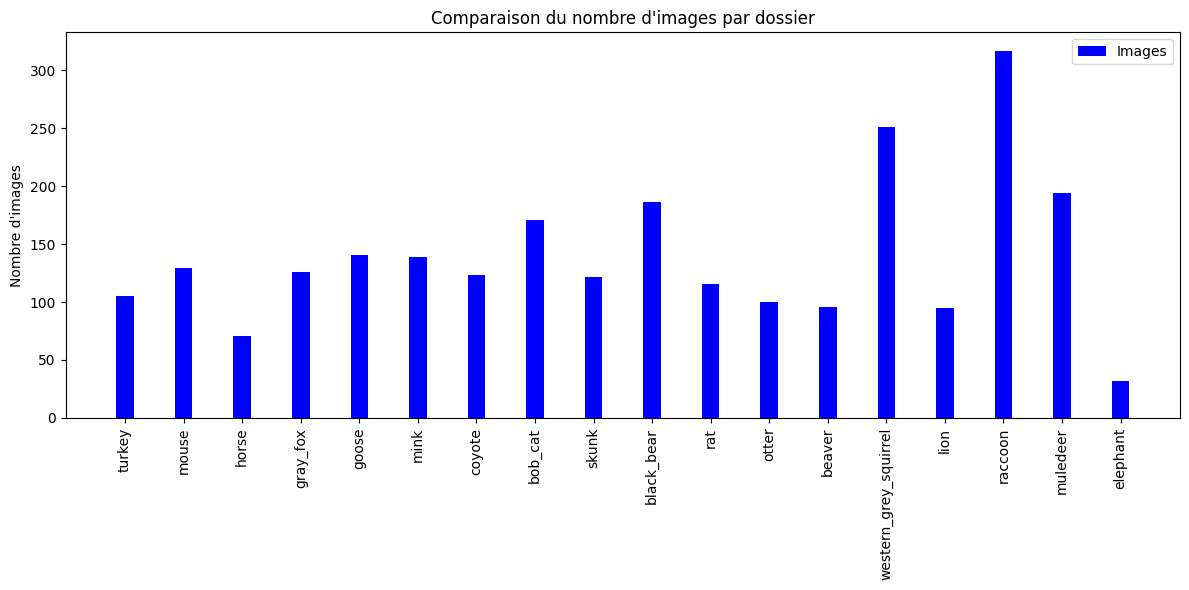

In [239]:
# Définition des chemins des datasets
image = "ressource/image/train"
# Fonction pour récupérer les infos des images d'un dossier (en gérant les dossiers absents)
def get_image_info(folder_path):
    if not os.path.exists(folder_path):  # 📌 Vérifie si le dossier existe
        return 0, None, None  # ⚠️ Si absent → 0 images et tailles nulles

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    num_images = len(image_files)

    if num_images == 0:
        return num_images, None, None  # Aucun fichier image

    widths, heights = [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_width = sum(widths) / len(widths) if widths else None
    avg_height = sum(heights) / len(heights) if heights else None

    return num_images, avg_width, avg_height

# Listes pour stocker les infos
image_data = []

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:
    # ✂️ Images recadrées - entraînement
    folder_path_train = os.path.join(image, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data.append([folder, num_images_train, avg_width_train, avg_height_train])

# Création des DataFrames
df_image = pd.DataFrame(image_data, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])

# Affichage du DataFrame de comparaison
display(df_image)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12,6))

x_labels = df_image["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, df_image["Nombre d'images"], width=0.3, label="Images", color='blue')

plt.xticks([x for x in x_range], x_labels, rotation=90)  # Centrage des labels
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.tight_layout()
plt.show()



# Augmentation des images
## Data Augmentation et Transformation des Données
La Data Augmentation est une technique utilisée en apprentissage automatique, notamment en vision par ordinateur et en traitement du langage naturel (NLP), pour augmenter la diversité des données d'entraînement sans collecter de nouvelles données. Elle permet de rendre les modèles plus robustes et d'améliorer leur généralisation.

- Calculer la Mediane du nombre des images
- Determiner le Q3 afin que le nombre d'image finale de chaque animale se rapproche
- Calculer le coefficient de multiplication pour chaque classe d'animaux
- Modifier et sauvegarder les nouvelles images
-

In [240]:
# 📂 Définition du chemin des images
image = "ressource/image/train"
augmented_image_folder = "ressource/image/augmented_train"

# 📝 Étape 1 : Calculer la médiane et Q3 du nombre d'images
median_images = df_image["Nombre d'images"].median()
q3_images = df_image["Nombre d'images"].quantile(0.75)

print(f"Médiane: {median_images}, Q3: {q3_images}")


Médiane: 124.5, Q3: 163.5


In [241]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import albumentations as A

# Création du dossier de sortie s'il n'existe pas
os.makedirs(augmented_image_folder, exist_ok=True)

# Calcul de la médiane et du Q3 pour équilibrer le dataset
median_images = df_image["Nombre d'images"].median()
q3_images = df_image["Nombre d'images"].quantile(0.75)

# Détermination du coefficient de Data Augmentation
df_image["Coeff"] = np.ceil(q3_images / df_image["Nombre d'images"])

# Définition des transformations sans PyTorch
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.5),
    A.GaussNoise(p=0.1),
    A.Resize(256, 256)  # Redimensionne sans ToTensorV2
])

# Boucle sur chaque classe d’animaux
for index, row in df_image.iterrows():
    if row["Coeff"] < 4 :
        folder_name = row["Nom du dossier"]
        coeff = int(row["Coeff"])

        original_folder = os.path.join(image, folder_name)
        augmented_folder = os.path.join(augmented_image_folder, folder_name)
        os.makedirs(augmented_folder, exist_ok=True)

        image_files = [f for f in os.listdir(original_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

        for img_file in image_files:
            img_path = os.path.join(original_folder, img_file)
            img = cv2.imread(img_path)  # Lecture avec OpenCV (BGR)

            if img is None:
                print(f"❌ Erreur de lecture de l'image {img_file}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Conversion en RGB (évite les problèmes de couleur)

            for i in range(coeff):  # Générer plusieurs images augmentées
                augmented = augmentation(image=img)["image"]
                new_img_path = os.path.join(augmented_folder, f"aug_{i}_{img_file}")
                cv2.imwrite(new_img_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))  # Sauvegarde avec OpenCV

print("✅ Data Augmentation terminée avec succès !")


✅ Data Augmentation terminée avec succès !


Nom du dossier  Nombre d'images  Largeur Moyenne  Hauteur Moyenne
0                  turkey              210            256.0            256.0
1                   mouse              258            256.0            256.0
2                   horse              213            256.0            256.0
3                gray_fox              252            256.0            256.0
4                   goose              282            256.0            256.0
5                    mink              278            256.0            256.0
6                  coyote              246            256.0            256.0
7                 bob_cat              171            256.0            256.0
8                   skunk              244            256.0            256.0
9              black_bear              186            256.0            256.0
10                    rat              232            256.0            256.0
11                  otter              200            256.0            256.0
12                 beaver              192            256.0            256.0
13  western_grey_squirrel              251            256.0            256.0
14                   lion              190            256.0            256.0
15                raccoon              317            256.0            256.0
16               muledeer              194            256.0            256.0
17               elephant                0              NaN              NaN

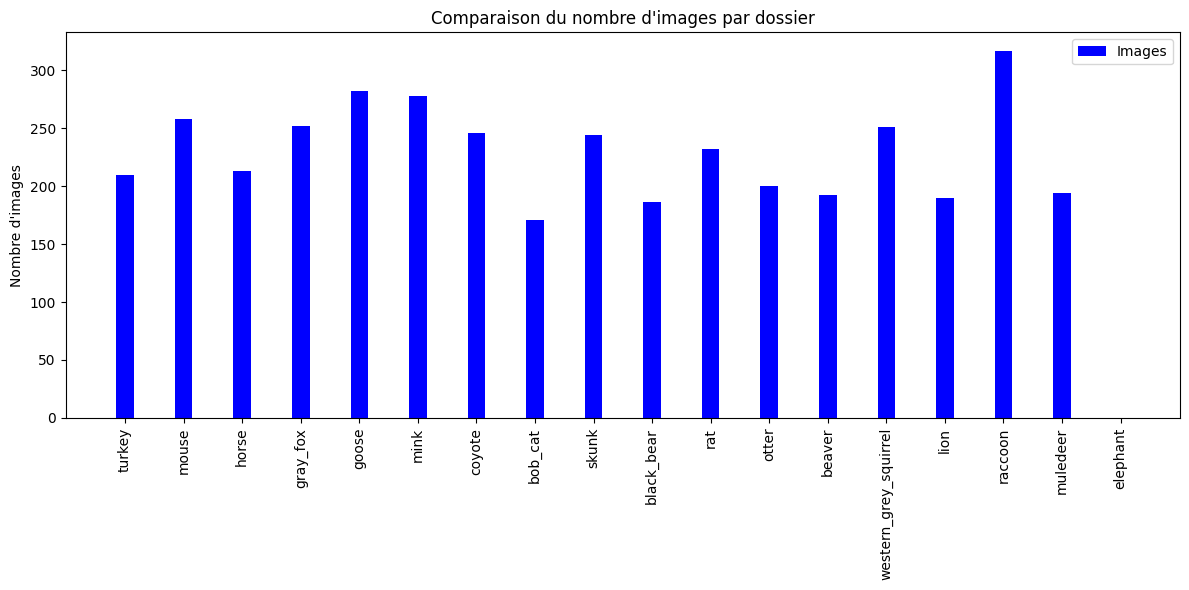

In [242]:
# Listes pour stocker les infos
image_data_new = []
image_new = "ressource/image/augmented_train"

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:
    # ✂️ Images recadrées - entraînement
    folder_path_train = os.path.join(image_new, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data_new.append([folder, num_images_train, avg_width_train, avg_height_train])

# Création des DataFrames
image_data_new = pd.DataFrame(image_data_new, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])

# Affichage du DataFrame de comparaison
display(image_data_new)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12,6))

x_labels = image_data_new["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, image_data_new["Nombre d'images"], width=0.3, label="Images", color='blue')

plt.xticks([x for x in x_range], x_labels, rotation=90)  # Centrage des labels
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.tight_layout()
plt.show()

In [243]:
display(image_data_new)
display(df_image)

Nom du dossier  Nombre d'images  Largeur Moyenne  Hauteur Moyenne
0                  turkey              210            256.0            256.0
1                   mouse              258            256.0            256.0
2                   horse              213            256.0            256.0
3                gray_fox              252            256.0            256.0
4                   goose              282            256.0            256.0
5                    mink              278            256.0            256.0
6                  coyote              246            256.0            256.0
7                 bob_cat              171            256.0            256.0
8                   skunk              244            256.0            256.0
9              black_bear              186            256.0            256.0
10                    rat              232            256.0            256.0
11                  otter              200            256.0            256.0
12                 beaver              192            256.0            256.0
13  western_grey_squirrel              251            256.0            256.0
14                   lion              190            256.0            256.0
15                raccoon              317            256.0            256.0
16               muledeer              194            256.0            256.0
17               elephant                0              NaN              NaN

Nom du dossier  Nombre d'images  Largeur Moyenne  Hauteur Moyenne  \
0                  turkey              105       411.371429       398.304762   
1                   mouse              129       152.310078       159.891473   
2                   horse               71       383.521127       340.492958   
3                gray_fox              126       278.182540       283.531746   
4                   goose              141       329.971631       311.737589   
5                    mink              139       302.273381       293.719424   
6                  coyote              123       359.276423       405.422764   
7                 bob_cat              171       250.976608       258.438596   
8                   skunk              122       442.180328       504.950820   
9              black_bear              186       447.930108       421.924731   
10                    rat              116       208.051724       204.767241   
11                  otter              100       396.380000       352.890000   
12                 beaver               96       271.531250       279.572917   
13  western_grey_squirrel              251       279.227092       287.609562   
14                   lion               95       370.610526       385.273684   
15                raccoon              317       210.488959       209.902208   
16               muledeer              194       322.103093       324.932990   
17               elephant               32       652.687500       580.812500   

    Coeff  
0     2.0  
1     2.0  
2     3.0  
3     2.0  
4     2.0  
5     2.0  
6     2.0  
7     1.0  
8     2.0  
9     1.0  
10    2.0  
11    2.0  
12    2.0  
13    1.0  
14    2.0  
15    1.0  
16    1.0  
17    6.0

## Labélisation
Le dataframe d'images et les métadata sont fusionnées afin que chaque image corresponde à des métadonnées : c'est la labélisation.

In [244]:
df_metadata = pd.read_csv("./ressource/metadata.csv")

df_merged = pd.merge(image_data_new, df_metadata, left_on='Nom du dossier', right_on='Espèce anglais', how='left')

print(df_merged)
print(df_merged.shape)
print(df_merged.head(10))

df_merged.to_csv("./ressource/data_merged.csv", header=True)

if print(df_merged['Espèce anglais'].isna().sum()):
    print("Toutes les lignes ont trouvés une correspondance")
display(df_merged)

           Nom du dossier  Nombre d'images  Largeur Moyenne  Hauteur Moyenne  \
0                  turkey              210            256.0            256.0   
1                   mouse              258            256.0            256.0   
2                   horse              213            256.0            256.0   
3                gray_fox              252            256.0            256.0   
4                   goose              282            256.0            256.0   
5                    mink              278            256.0            256.0   
6                  coyote              246            256.0            256.0   
7                 bob_cat              171            256.0            256.0   
8                   skunk              244            256.0            256.0   
9              black_bear              186            256.0            256.0   
10                    rat              232            256.0            256.0   
11                  otter              2

Nom du dossier  Nombre d'images  Largeur Moyenne  Hauteur Moyenne  \
0                  turkey              210            256.0            256.0   
1                   mouse              258            256.0            256.0   
2                   horse              213            256.0            256.0   
3                gray_fox              252            256.0            256.0   
4                   goose              282            256.0            256.0   
5                    mink              278            256.0            256.0   
6                  coyote              246            256.0            256.0   
7                 bob_cat              171            256.0            256.0   
8                   skunk              244            256.0            256.0   
9              black_bear              186            256.0            256.0   
10                    rat              232            256.0            256.0   
11                  otter              200            256.0            256.0   
12                 beaver              192            256.0            256.0   
13  western_grey_squirrel              251            256.0            256.0   
14                   lion              190            256.0            256.0   
15                raccoon              317            256.0            256.0   
16               muledeer              194            256.0            256.0   
17               elephant                0              NaN              NaN   

           Espèce anglais           Espèce français      Famille  \
0                  turkey                     Dinde  Phasianidae   
1                   mouse                    souris      Muridae   
2                   horse                    cheval      Equidae   
3                gray_fox               Renard gris      Canidae   
4                   goose                       oie     Anatidae   
5                    mink            Vison d'Europe   Mustelidae   
6                  coyote                    Coyote      Canidae   
7                 bob_cat           Chat domestique      Felidae   
8                   skunk                    Putois   Mustelidae   
9              black_bear                 Ours noir      Ursidae   
10                    rat                       rat      Muridae   
11                  otter                    loutre   Mustelidae   
12                 beaver                    Castor   Castoridae   
13  western_grey_squirrel  écureuil gris de l'Ouest    Sciuridae   
14                   lion                      lion      Felidae   
15                raccoon              raton laveur  Procyonidae   
16               muledeer                cerf mulet     Cervidae   
17               elephant                  éléphant  Proboscidés   

                   Nom latin  \
0        Meleagris gallopavo   
1               Mus musculus   
2       Equus ferus caballus   
3   Urocyon cinereoargenteus   
4                Anser anser   
5              Neogale vison   
6              Canis latrans   
7                Felis catus   
8          Mephitis mephitis   
9           Ursus americanus   
10         Rattus norvegicus   
11               Lutra lutra   
12              Castor fiber   
13      Sciurus carolinensis   
14              Panthera leo   
15             Procyon lotor   
16       Odocoileus hemionus   
17        Loxodonta africana   

                                          Description  Population estimée  \
0   Oiseau de grande taille au plumage coloré, ori...           550000000   
1   Petit rongeur avec de grandes oreilles et une ...           600000000   
2   Mammifère quadrupède au corps robuste, au cou ...            58000000   
3   Le renard gris est un petit canidé aux poils g...             4000000   
4   L'oie est un grand oiseau aquatique avec un co...             2500000   
5   Petit mammifère semi-aquatique avec un pelage ...             1000000   
6   Le coyote est un canidé de taille moyenne, av

# State
Ajout d'un state aléatoire sur chaque image.

70% de train (1)

15% de test (2)

15% de val (3)

Ceci servira prochainement pour l'entrainement du model de machine learning


In [245]:
from pyspark.sql.functions import rand, when, col

df_merged_spark = spark.createDataFrame(df_merged)
image_new = "ressource/image/augmented_train"

df_dict = {}
for dossier in df_merged_spark.select("Nom du dossier").distinct().rdd.flatMap(lambda x: x).collect():
    folder_path = os.path.join(image_new, dossier)
    if os.path.exists(folder_path):
        df_images = spark.createDataFrame([(dossier, os.path.join(dossier, img)) for img in os.listdir(folder_path)],
                                          ["Nom du dossier", "Chemin Relatif"])
        df_dict[dossier] = df_images.join(df_merged_spark, on="Nom du dossier", how="left")

for dossier, df in df_dict.items():
    df.write.mode("overwrite").parquet(f"ressource/dataframes_parquet/{dossier}")
    df.write.mode("overwrite").csv(f"ressource/dataframes_csv/{dossier}")

train_ratio = 0.8
val_ratio = 0.1

for dossier, df in df_dict.items():

    df = df.withColumn("rand_val", rand())

    df = df.withColumn(
        "state",
        when(col("rand_val") <= train_ratio, 1)
        .when(col("rand_val") <= (train_ratio + val_ratio), 2)
        .otherwise(3)
    )

    df_dict[dossier] = df

    df.write.mode("overwrite").parquet(f"ressource/dataframes_parquet/{dossier}")
    df.write.mode("overwrite").csv(f"ressource/dataframes_csv/{dossier}")

    print(f"✅ State ajouté et fichier enregistré pour {dossier}")

from functools import reduce
from pyspark.sql import DataFrame

if df_dict:
    df_final = reduce(DataFrame.unionAll, df_dict.values())
    print(f" Fusion complète ! Le DataFrame final contient {df_final.count()} images.")
    df_final.write.mode("overwrite").parquet("ressource/dataframes_parquet/all_images")
    df_final.coalesce(1).write.mode("overwrite").csv("ressource/dataframes_csv/all_images", header=True)
else:
    print("⚠️ Aucun DataFrame à fusionner !")



25/03/05 21:48:02 INFO CodeGenerator: Code generated in 10.526109 ms
25/03/05 21:48:02 INFO DAGScheduler: Registering RDD 8212 (javaToPython at NativeMethodAccessorImpl.java:0) as input to shuffle 1567
25/03/05 21:48:02 INFO DAGScheduler: Got map stage job 2809 (javaToPython at NativeMethodAccessorImpl.java:0) with 16 output partitions
25/03/05 21:48:02 INFO DAGScheduler: Final stage: ShuffleMapStage 4546 (javaToPython at NativeMethodAccessorImpl.java:0)
25/03/05 21:48:02 INFO DAGScheduler: Parents of final stage: List()
25/03/05 21:48:02 INFO DAGScheduler: Missing parents: List()
25/03/05 21:48:02 INFO DAGScheduler: Submitting ShuffleMapStage 4546 (MapPartitionsRDD[8212] at javaToPython at NativeMethodAccessorImpl.java:0), which has no missing parents
25/03/05 21:48:02 INFO MemoryStore: Block broadcast_3437 stored as values in memory (estimated size 28.1 KiB, free 432.2 MiB)
25/03/05 21:48:02 INFO MemoryStore: Block broadcast_3437_piece0 stored as bytes in memory (estimated size 13.1 

✅ State ajouté et fichier enregistré pour turkey


25/03/05 21:48:14 INFO PythonRunner: Times: total = 73, boot = -146, init = 219, finish = 0
25/03/05 21:48:14 INFO PythonRunner: Times: total = 74, boot = -134, init = 208, finish = 0
25/03/05 21:48:14 INFO PythonRunner: Times: total = 74, boot = -130, init = 204, finish = 0
25/03/05 21:48:14 INFO PythonRunner: Times: total = 77, boot = -152, init = 229, finish = 0
25/03/05 21:48:14 INFO Executor: Finished task 5.0 in stage 4765.0 (TID 26668). 2339 bytes result sent to driver
25/03/05 21:48:14 INFO PythonRunner: Times: total = 73, boot = -185, init = 257, finish = 1
25/03/05 21:48:14 INFO Executor: Finished task 6.0 in stage 4765.0 (TID 26669). 2339 bytes result sent to driver
25/03/05 21:48:14 INFO Executor: Finished task 8.0 in stage 4765.0 (TID 26671). 2296 bytes result sent to driver
25/03/05 21:48:14 INFO TaskSetManager: Starting task 0.0 in stage 4766.0 (TID 26679) (172.20.100.137, executor driver, partition 0, PROCESS_LOCAL, 9183 bytes) 
25/03/05 21:48:14 INFO TaskSetManager: St

✅ State ajouté et fichier enregistré pour mouse


25/03/05 21:48:15 INFO PythonRunner: Times: total = 72, boot = -84, init = 156, finish = 0
25/03/05 21:48:15 INFO PythonRunner: Times: total = 74, boot = -81, init = 155, finish = 0
25/03/05 21:48:15 INFO PythonRunner: Times: total = 72, boot = -140, init = 212, finish = 0
25/03/05 21:48:15 INFO Executor: Finished task 0.0 in stage 4777.0 (TID 26731). 2339 bytes result sent to driver
25/03/05 21:48:15 INFO TaskSetManager: Starting task 0.0 in stage 4778.0 (TID 26747) (172.20.100.137, executor driver, partition 0, PROCESS_LOCAL, 9183 bytes) 
25/03/05 21:48:15 INFO PythonRunner: Times: total = 75, boot = -84, init = 159, finish = 0
25/03/05 21:48:15 INFO TaskSetManager: Finished task 0.0 in stage 4777.0 (TID 26731) in 85 ms on 172.20.100.137 (executor driver) (1/16)
25/03/05 21:48:15 INFO Executor: Finished task 10.0 in stage 4777.0 (TID 26741). 2339 bytes result sent to driver
25/03/05 21:48:15 INFO TaskSetManager: Starting task 1.0 in stage 4778.0 (TID 26748) (172.20.100.137, executor 

✅ State ajouté et fichier enregistré pour horse


25/03/05 21:48:15 INFO DAGScheduler: Registering RDD 8665 (parquet at <unknown>:0) as input to shuffle 1648
25/03/05 21:48:15 INFO DAGScheduler: Got map stage job 2971 (parquet at <unknown>:0) with 16 output partitions
25/03/05 21:48:15 INFO DAGScheduler: Final stage: ShuffleMapStage 4789 (parquet at <unknown>:0)
25/03/05 21:48:15 INFO DAGScheduler: Parents of final stage: List()
25/03/05 21:48:15 INFO DAGScheduler: Missing parents: List()
25/03/05 21:48:15 INFO DAGScheduler: Submitting ShuffleMapStage 4789 (MapPartitionsRDD[8665] at parquet at <unknown>:0), which has no missing parents
25/03/05 21:48:15 INFO MemoryStore: Block broadcast_3639 stored as values in memory (estimated size 15.2 KiB, free 429.4 MiB)
25/03/05 21:48:15 INFO MemoryStore: Block broadcast_3639_piece0 stored as bytes in memory (estimated size 8.0 KiB, free 429.3 MiB)
25/03/05 21:48:15 INFO BlockManagerInfo: Added broadcast_3639_piece0 in memory on 172.20.100.137:43229 (size: 8.0 KiB, free: 434.1 MiB)
25/03/05 21:4

✅ State ajouté et fichier enregistré pour gray_fox


25/03/05 21:48:16 INFO PythonRunner: Times: total = 92, boot = 6, init = 86, finish = 0
25/03/05 21:48:16 INFO PythonRunner: Times: total = 90, boot = 14, init = 76, finish = 0
25/03/05 21:48:16 INFO PythonRunner: Times: total = 101, boot = 15, init = 86, finish = 0
25/03/05 21:48:16 INFO PythonRunner: Times: total = 102, boot = 7, init = 95, finish = 0
25/03/05 21:48:16 INFO Executor: Finished task 3.0 in stage 4802.0 (TID 26886). 2395 bytes result sent to driver
25/03/05 21:48:16 INFO Executor: Finished task 0.0 in stage 4802.0 (TID 26883). 2395 bytes result sent to driver
25/03/05 21:48:16 INFO TaskSetManager: Finished task 3.0 in stage 4802.0 (TID 26886) in 115 ms on 172.20.100.137 (executor driver) (1/16)
25/03/05 21:48:16 INFO TaskSetManager: Finished task 0.0 in stage 4802.0 (TID 26883) in 118 ms on 172.20.100.137 (executor driver) (2/16)
25/03/05 21:48:16 INFO Executor: Finished task 5.0 in stage 4802.0 (TID 26888). 2395 bytes result sent to driver
25/03/05 21:48:16 INFO Python

✅ State ajouté et fichier enregistré pour goose


25/03/05 21:48:17 INFO PythonRunner: Times: total = 82, boot = 7, init = 75, finish = 0
25/03/05 21:48:17 INFO Executor: Finished task 0.0 in stage 4814.0 (TID 26951). 2395 bytes result sent to driver
25/03/05 21:48:17 INFO TaskSetManager: Finished task 0.0 in stage 4814.0 (TID 26951) in 97 ms on 172.20.100.137 (executor driver) (1/16)
25/03/05 21:48:17 INFO PythonRunner: Times: total = 80, boot = 4, init = 76, finish = 0
25/03/05 21:48:17 INFO Executor: Finished task 1.0 in stage 4814.0 (TID 26952). 2395 bytes result sent to driver
25/03/05 21:48:17 INFO TaskSetManager: Finished task 1.0 in stage 4814.0 (TID 26952) in 96 ms on 172.20.100.137 (executor driver) (2/16)
25/03/05 21:48:17 INFO PythonRunner: Times: total = 85, boot = 11, init = 74, finish = 0
25/03/05 21:48:17 INFO Executor: Finished task 7.0 in stage 4814.0 (TID 26958). 2395 bytes result sent to driver
25/03/05 21:48:17 INFO TaskSetManager: Finished task 7.0 in stage 4814.0 (TID 26958) in 97 ms on 172.20.100.137 (executor 

✅ State ajouté et fichier enregistré pour mink


25/03/05 21:48:18 INFO TaskSetManager: Finished task 14.0 in stage 4825.0 (TID 27017) in 124 ms on 172.20.100.137 (executor driver) (16/16)
25/03/05 21:48:18 INFO TaskSchedulerImpl: Removed TaskSet 4825.0, whose tasks have all completed, from pool 
25/03/05 21:48:18 INFO DAGScheduler: ShuffleMapStage 4825 (parquet at <unknown>:0) finished in 0.126 s
25/03/05 21:48:18 INFO DAGScheduler: looking for newly runnable stages
25/03/05 21:48:18 INFO DAGScheduler: running: Set(ShuffleMapStage 4826)
25/03/05 21:48:18 INFO DAGScheduler: waiting: Set()
25/03/05 21:48:18 INFO DAGScheduler: failed: Set()
25/03/05 21:48:18 INFO TaskSetManager: Starting task 15.0 in stage 4826.0 (TID 27034) (172.20.100.137, executor driver, partition 15, PROCESS_LOCAL, 9497 bytes) 
25/03/05 21:48:18 INFO Executor: Running task 15.0 in stage 4826.0 (TID 27034)
25/03/05 21:48:18 INFO PythonRunner: Times: total = 88, boot = 5, init = 83, finish = 0
25/03/05 21:48:18 INFO Executor: Finished task 4.0 in stage 4826.0 (TID 2

✅ State ajouté et fichier enregistré pour coyote


25/03/05 21:48:18 INFO PythonRunner: Times: total = 79, boot = -95, init = 174, finish = 0
25/03/05 21:48:18 INFO PythonRunner: Times: total = 81, boot = -84, init = 165, finish = 0
25/03/05 21:48:18 INFO Executor: Finished task 11.0 in stage 4837.0 (TID 27082). 2339 bytes result sent to driver
25/03/05 21:48:18 INFO PythonRunner: Times: total = 83, boot = -82, init = 164, finish = 1
25/03/05 21:48:18 INFO TaskSetManager: Starting task 0.0 in stage 4838.0 (TID 27087) (172.20.100.137, executor driver, partition 0, PROCESS_LOCAL, 9183 bytes) 
25/03/05 21:48:18 INFO Executor: Running task 0.0 in stage 4838.0 (TID 27087)
25/03/05 21:48:18 INFO TaskSetManager: Finished task 11.0 in stage 4837.0 (TID 27082) in 91 ms on 172.20.100.137 (executor driver) (1/16)
25/03/05 21:48:18 INFO PythonRunner: Times: total = 81, boot = -84, init = 165, finish = 0
25/03/05 21:48:18 INFO PythonRunner: Times: total = 85, boot = -125, init = 210, finish = 0
25/03/05 21:48:18 INFO PythonRunner: Times: total = 88

✅ State ajouté et fichier enregistré pour bob_cat


25/03/05 21:48:19 INFO PythonRunner: Times: total = 70, boot = -126, init = 195, finish = 1
25/03/05 21:48:19 INFO PythonRunner: Times: total = 70, boot = -71, init = 141, finish = 0
25/03/05 21:48:19 INFO Executor: Finished task 13.0 in stage 4849.0 (TID 27152). 2339 bytes result sent to driver
25/03/05 21:48:19 INFO PythonRunner: Times: total = 73, boot = -94, init = 166, finish = 1
25/03/05 21:48:19 INFO TaskSetManager: Starting task 0.0 in stage 4850.0 (TID 27155) (172.20.100.137, executor driver, partition 0, PROCESS_LOCAL, 9183 bytes) 
25/03/05 21:48:19 INFO PythonRunner: Times: total = 70, boot = -72, init = 142, finish = 0
25/03/05 21:48:19 INFO TaskSetManager: Finished task 13.0 in stage 4849.0 (TID 27152) in 81 ms on 172.20.100.137 (executor driver) (1/16)
25/03/05 21:48:19 INFO PythonRunner: Times: total = 74, boot = -75, init = 149, finish = 0
25/03/05 21:48:19 INFO Executor: Finished task 10.0 in stage 4849.0 (TID 27149). 2339 bytes result sent to driver
25/03/05 21:48:19 

✅ State ajouté et fichier enregistré pour skunk


25/03/05 21:48:20 INFO Executor: Finished task 1.0 in stage 4862.0 (TID 27224). 2395 bytes result sent to driver
25/03/05 21:48:20 INFO TaskSetManager: Finished task 1.0 in stage 4862.0 (TID 27224) in 100 ms on 172.20.100.137 (executor driver) (1/16)
25/03/05 21:48:20 INFO PythonRunner: Times: total = 95, boot = 22, init = 73, finish = 0
25/03/05 21:48:20 INFO PythonRunner: Times: total = 94, boot = 12, init = 82, finish = 0
25/03/05 21:48:20 INFO Executor: Finished task 0.0 in stage 4862.0 (TID 27223). 2438 bytes result sent to driver
25/03/05 21:48:20 INFO PythonRunner: Times: total = 97, boot = 18, init = 79, finish = 0
25/03/05 21:48:20 INFO TaskSetManager: Finished task 0.0 in stage 4862.0 (TID 27223) in 109 ms on 172.20.100.137 (executor driver) (2/16)
25/03/05 21:48:20 INFO Executor: Finished task 2.0 in stage 4862.0 (TID 27225). 2395 bytes result sent to driver
25/03/05 21:48:20 INFO TaskSetManager: Finished task 2.0 in stage 4862.0 (TID 27225) in 111 ms on 172.20.100.137 (exec

✅ State ajouté et fichier enregistré pour black_bear


25/03/05 21:48:20 INFO PythonRunner: Times: total = 135, boot = -94, init = 229, finish = 0
25/03/05 21:48:20 INFO Executor: Finished task 14.0 in stage 4873.0 (TID 27289). 2339 bytes result sent to driver
25/03/05 21:48:20 INFO TaskSetManager: Starting task 15.0 in stage 4874.0 (TID 27306) (172.20.100.137, executor driver, partition 15, PROCESS_LOCAL, 9497 bytes) 
25/03/05 21:48:20 INFO TaskSetManager: Finished task 14.0 in stage 4873.0 (TID 27289) in 145 ms on 172.20.100.137 (executor driver) (16/16)
25/03/05 21:48:20 INFO TaskSchedulerImpl: Removed TaskSet 4873.0, whose tasks have all completed, from pool 
25/03/05 21:48:20 INFO Executor: Running task 15.0 in stage 4874.0 (TID 27306)
25/03/05 21:48:20 INFO DAGScheduler: ShuffleMapStage 4873 (parquet at <unknown>:0) finished in 0.150 s
25/03/05 21:48:20 INFO DAGScheduler: looking for newly runnable stages
25/03/05 21:48:20 INFO DAGScheduler: running: Set(ShuffleMapStage 4874)
25/03/05 21:48:20 INFO DAGScheduler: waiting: Set()
25/03/

✅ State ajouté et fichier enregistré pour rat


25/03/05 21:48:21 INFO PythonRunner: Times: total = 113, boot = -109, init = 222, finish = 0
25/03/05 21:48:21 INFO Executor: Finished task 0.0 in stage 4885.0 (TID 27343). 2382 bytes result sent to driver
25/03/05 21:48:21 INFO TaskSetManager: Starting task 14.0 in stage 4886.0 (TID 27373) (172.20.100.137, executor driver, partition 14, PROCESS_LOCAL, 9215 bytes) 
25/03/05 21:48:21 INFO Executor: Running task 14.0 in stage 4886.0 (TID 27373)
25/03/05 21:48:21 INFO TaskSetManager: Finished task 0.0 in stage 4885.0 (TID 27343) in 126 ms on 172.20.100.137 (executor driver) (15/16)
25/03/05 21:48:21 INFO PythonRunner: Times: total = 125, boot = -120, init = 245, finish = 0
25/03/05 21:48:21 INFO Executor: Finished task 2.0 in stage 4885.0 (TID 27345). 2339 bytes result sent to driver
25/03/05 21:48:21 INFO TaskSetManager: Finished task 2.0 in stage 4885.0 (TID 27345) in 131 ms on 172.20.100.137 (executor driver) (16/16)
25/03/05 21:48:21 INFO TaskSchedulerImpl: Removed TaskSet 4885.0, who

✅ State ajouté et fichier enregistré pour otter


25/03/05 21:48:22 INFO PythonRunner: Times: total = 72, boot = -123, init = 195, finish = 0
25/03/05 21:48:22 INFO PythonRunner: Times: total = 76, boot = -96, init = 172, finish = 0
25/03/05 21:48:22 INFO PythonRunner: Times: total = 75, boot = -107, init = 182, finish = 0
25/03/05 21:48:22 INFO Executor: Finished task 2.0 in stage 4897.0 (TID 27413). 2296 bytes result sent to driver
25/03/05 21:48:22 INFO TaskSetManager: Starting task 0.0 in stage 4898.0 (TID 27427) (172.20.100.137, executor driver, partition 0, PROCESS_LOCAL, 9183 bytes) 
25/03/05 21:48:22 INFO PythonRunner: Times: total = 74, boot = -86, init = 160, finish = 0
25/03/05 21:48:22 INFO PythonRunner: Times: total = 73, boot = -79, init = 152, finish = 0
25/03/05 21:48:22 INFO Executor: Running task 0.0 in stage 4898.0 (TID 27427)
25/03/05 21:48:22 INFO Executor: Finished task 15.0 in stage 4897.0 (TID 27426). 2296 bytes result sent to driver
25/03/05 21:48:22 INFO Executor: Finished task 8.0 in stage 4897.0 (TID 27419)

✅ State ajouté et fichier enregistré pour beaver


25/03/05 21:48:22 INFO PythonRunner: Times: total = 74, boot = -83, init = 157, finish = 0
25/03/05 21:48:22 INFO Executor: Finished task 15.0 in stage 4909.0 (TID 27494). 2339 bytes result sent to driver
25/03/05 21:48:22 INFO PythonRunner: Times: total = 81, boot = -140, init = 221, finish = 0
25/03/05 21:48:22 INFO PythonRunner: Times: total = 76, boot = -95, init = 171, finish = 0
25/03/05 21:48:22 INFO PythonRunner: Times: total = 81, boot = -110, init = 191, finish = 0
25/03/05 21:48:22 INFO BlockManagerInfo: Removed broadcast_3726_piece0 on 172.20.100.137:43229 in memory (size: 4.2 KiB, free: 434.1 MiB)
25/03/05 21:48:22 INFO TaskSetManager: Starting task 0.0 in stage 4910.0 (TID 27495) (172.20.100.137, executor driver, partition 0, PROCESS_LOCAL, 9183 bytes) 
25/03/05 21:48:22 INFO Executor: Finished task 11.0 in stage 4909.0 (TID 27490). 2382 bytes result sent to driver
25/03/05 21:48:22 INFO TaskSetManager: Finished task 15.0 in stage 4909.0 (TID 27494) in 126 ms on 172.20.10

✅ State ajouté et fichier enregistré pour western_grey_squirrel


25/03/05 21:48:23 INFO PythonRunner: Times: total = 82, boot = 9, init = 73, finish = 0
25/03/05 21:48:23 INFO PythonRunner: Times: total = 84, boot = 6, init = 78, finish = 0
25/03/05 21:48:23 INFO PythonRunner: Times: total = 92, boot = 11, init = 81, finish = 0
25/03/05 21:48:23 INFO Executor: Finished task 5.0 in stage 4922.0 (TID 27568). 2395 bytes result sent to driver
25/03/05 21:48:23 INFO TaskSetManager: Finished task 5.0 in stage 4922.0 (TID 27568) in 91 ms on 172.20.100.137 (executor driver) (1/16)
25/03/05 21:48:23 INFO PythonRunner: Times: total = 95, boot = 18, init = 77, finish = 0
25/03/05 21:48:23 INFO Executor: Finished task 4.0 in stage 4922.0 (TID 27567). 2395 bytes result sent to driver
25/03/05 21:48:23 INFO TaskSetManager: Finished task 4.0 in stage 4922.0 (TID 27567) in 99 ms on 172.20.100.137 (executor driver) (2/16)
25/03/05 21:48:23 INFO Executor: Finished task 6.0 in stage 4922.0 (TID 27569). 2395 bytes result sent to driver
25/03/05 21:48:23 INFO PythonRunn

✅ State ajouté et fichier enregistré pour lion


25/03/05 21:48:24 INFO Executor: Running task 11.0 in stage 4934.0 (TID 27642)
25/03/05 21:48:24 INFO Executor: Running task 9.0 in stage 4934.0 (TID 27640)
25/03/05 21:48:24 INFO Executor: Running task 12.0 in stage 4934.0 (TID 27643)
25/03/05 21:48:24 INFO Executor: Finished task 5.0 in stage 4933.0 (TID 27620). 2339 bytes result sent to driver
25/03/05 21:48:24 INFO TaskSetManager: Starting task 14.0 in stage 4934.0 (TID 27645) (172.20.100.137, executor driver, partition 14, PROCESS_LOCAL, 9215 bytes) 
25/03/05 21:48:24 INFO Executor: Running task 14.0 in stage 4934.0 (TID 27645)
25/03/05 21:48:24 INFO TaskSetManager: Finished task 5.0 in stage 4933.0 (TID 27620) in 131 ms on 172.20.100.137 (executor driver) (15/16)
25/03/05 21:48:24 INFO PythonRunner: Times: total = 153, boot = -82, init = 235, finish = 0
25/03/05 21:48:24 INFO Executor: Finished task 12.0 in stage 4933.0 (TID 27627). 2339 bytes result sent to driver
25/03/05 21:48:24 INFO TaskSetManager: Starting task 15.0 in stag

✅ State ajouté et fichier enregistré pour raccoon


25/03/05 21:48:25 INFO PythonRunner: Times: total = 73, boot = -97, init = 170, finish = 0
25/03/05 21:48:25 INFO PythonRunner: Times: total = 73, boot = -129, init = 202, finish = 0
25/03/05 21:48:25 INFO PythonRunner: Times: total = 72, boot = -162, init = 234, finish = 0
25/03/05 21:48:25 INFO PythonRunner: Times: total = 73, boot = -170, init = 243, finish = 0
25/03/05 21:48:25 INFO Executor: Finished task 4.0 in stage 4945.0 (TID 27687). 2339 bytes result sent to driver
25/03/05 21:48:25 INFO TaskSetManager: Starting task 0.0 in stage 4946.0 (TID 27699) (172.20.100.137, executor driver, partition 0, PROCESS_LOCAL, 9183 bytes) 
25/03/05 21:48:25 INFO TaskSetManager: Finished task 4.0 in stage 4945.0 (TID 27687) in 80 ms on 172.20.100.137 (executor driver) (1/16)
25/03/05 21:48:25 INFO Executor: Running task 0.0 in stage 4946.0 (TID 27699)
25/03/05 21:48:25 INFO PythonRunner: Times: total = 75, boot = -117, init = 192, finish = 0
25/03/05 21:48:25 INFO Executor: Finished task 13.0 i

✅ State ajouté et fichier enregistré pour muledeer


25/03/05 21:48:25 INFO CodeGenerator: Code generated in 1.724753 ms
25/03/05 21:48:25 INFO DAGScheduler: Registering RDD 8917 (count at NativeMethodAccessorImpl.java:0) as input to shuffle 1704
25/03/05 21:48:25 INFO DAGScheduler: Got map stage job 3083 (count at NativeMethodAccessorImpl.java:0) with 16 output partitions
25/03/05 21:48:25 INFO DAGScheduler: Final stage: ShuffleMapStage 4957 (count at NativeMethodAccessorImpl.java:0)
25/03/05 21:48:25 INFO DAGScheduler: Parents of final stage: List()
25/03/05 21:48:25 INFO DAGScheduler: Missing parents: List()
25/03/05 21:48:25 INFO DAGScheduler: Submitting ShuffleMapStage 4957 (MapPartitionsRDD[8917] at count at NativeMethodAccessorImpl.java:0), which has no missing parents
25/03/05 21:48:25 INFO MemoryStore: Block broadcast_3779 stored as values in memory (estimated size 15.0 KiB, free 432.1 MiB)
25/03/05 21:48:25 INFO MemoryStore: Block broadcast_3779_piece0 stored as bytes in memory (estimated size 8.0 KiB, free 432.1 MiB)
25/03/05 

 Fusion complète ! Le DataFrame final contient 3916 images.


25/03/05 21:48:28 INFO PythonRunner: Times: total = 104, boot = -252, init = 355, finish = 1
25/03/05 21:48:28 INFO PythonRunner: Times: total = 80, boot = -270, init = 350, finish = 0
25/03/05 21:48:28 INFO Executor: Finished task 11.0 in stage 5014.0 (TID 28069). 2382 bytes result sent to driver
25/03/05 21:48:28 INFO TaskSetManager: Starting task 0.0 in stage 5015.0 (TID 28074) (172.20.100.137, executor driver, partition 0, PROCESS_LOCAL, 9183 bytes) 
25/03/05 21:48:28 INFO TaskSetManager: Finished task 11.0 in stage 5014.0 (TID 28069) in 136 ms on 172.20.100.137 (executor driver) (1/16)
25/03/05 21:48:28 INFO PythonRunner: Times: total = 80, boot = -206, init = 286, finish = 0
25/03/05 21:48:28 INFO PythonRunner: Times: total = 87, boot = -270, init = 357, finish = 0
25/03/05 21:48:28 INFO Executor: Finished task 0.0 in stage 5014.0 (TID 28058). 2382 bytes result sent to driver
25/03/05 21:48:28 INFO Executor: Running task 0.0 in stage 5015.0 (TID 28074)
25/03/05 21:48:28 INFO Task

root
 |-- Nom du dossier: string (nullable = true)
 |-- Chemin Relatif: string (nullable = true)
 |-- Nombre d'images: long (nullable = true)
 |-- Largeur Moyenne: double (nullable = true)
 |-- Hauteur Moyenne: double (nullable = true)
 |-- Espèce anglais: string (nullable = true)
 |-- Espèce français: string (nullable = true)
 |-- Famille: string (nullable = true)
 |-- Nom latin: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Population estimée: long (nullable = true)
 |-- Localisation: string (nullable = true)
 |-- rand_val: double (nullable = false)
 |-- state: integer (nullable = false)



25/03/05 21:48:33 INFO DAGScheduler: Registering RDD 9144 (showString at NativeMethodAccessorImpl.java:0) as input to shuffle 1759
25/03/05 21:48:33 INFO DAGScheduler: Got map stage job 3144 (showString at NativeMethodAccessorImpl.java:0) with 16 output partitions
25/03/05 21:48:33 INFO DAGScheduler: Final stage: ShuffleMapStage 5090 (showString at NativeMethodAccessorImpl.java:0)
25/03/05 21:48:33 INFO DAGScheduler: Parents of final stage: List()
25/03/05 21:48:33 INFO DAGScheduler: Missing parents: List()
25/03/05 21:48:33 INFO DAGScheduler: Submitting ShuffleMapStage 5090 (MapPartitionsRDD[9144] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
25/03/05 21:48:33 INFO MemoryStore: Block broadcast_3843 stored as values in memory (estimated size 15.2 KiB, free 431.9 MiB)
25/03/05 21:48:33 INFO MemoryStore: Block broadcast_3843_piece0 stored as bytes in memory (estimated size 8.0 KiB, free 431.9 MiB)
25/03/05 21:48:33 INFO BlockManagerInfo: Added broadcast_

+--------------+--------------------+---------------+---------------+---------------+--------------+---------------+-----------+-------------------+--------------------+------------------+------------------+-------------------+-----+
|Nom du dossier|      Chemin Relatif|Nombre d'images|Largeur Moyenne|Hauteur Moyenne|Espèce anglais|Espèce français|    Famille|          Nom latin|         Description|Population estimée|      Localisation|           rand_val|state|
+--------------+--------------------+---------------+---------------+---------------+--------------+---------------+-----------+-------------------+--------------------+------------------+------------------+-------------------+-----+
|        turkey|turkey/aug_1_2493...|            210|          256.0|          256.0|        turkey|          Dinde|Phasianidae|Meleagris gallopavo|Oiseau de grande ...|         550000000|États-Unis Mexique| 0.3967493214977724|    1|
|        turkey|turkey/aug_0_2442...|            210|          2

25/03/05 21:48:36 INFO BlockManagerInfo: Added broadcast_3874_piece0 in memory on 172.20.100.137:43229 (size: 8.0 KiB, free: 434.2 MiB)
25/03/05 21:48:36 INFO CodeGenerator: Code generated in 44.430188 ms
25/03/05 21:48:36 INFO PythonRunner: Times: total = 102, boot = -301, init = 403, finish = 0
25/03/05 21:48:36 INFO PythonRunner: Times: total = 107, boot = -309, init = 416, finish = 0
25/03/05 21:48:36 INFO PythonRunner: Times: total = 80, boot = -238, init = 318, finish = 0
25/03/05 21:48:36 INFO PythonRunner: Times: total = 70, boot = -310, init = 380, finish = 0
25/03/05 21:48:36 INFO PythonRunner: Times: total = 107, boot = -242, init = 349, finish = 0
25/03/05 21:48:36 INFO BlockManagerInfo: Removed broadcast_3859_piece0 on 172.20.100.137:43229 in memory (size: 8.0 KiB, free: 434.2 MiB)
25/03/05 21:48:36 INFO PythonRunner: Times: total = 94, boot = -291, init = 385, finish = 0
25/03/05 21:48:36 INFO Executor: Finished task 6.0 in stage 5128.0 (TID 28950). 2382 bytes result sent

Nombre total d'images : 3916
Colonnes : ['Nom du dossier', 'Chemin Relatif', "Nombre d'images", 'Largeur Moyenne', 'Hauteur Moyenne', 'Espèce anglais', 'Espèce français', 'Famille', 'Nom latin', 'Description', 'Population estimée', 'Localisation', 'rand_val', 'state']


25/03/05 21:48:39 INFO PythonRunner: Times: total = 141, boot = -153, init = 294, finish = 0
25/03/05 21:48:39 INFO Executor: Finished task 4.0 in stage 5185.0 (TID 29255). 2339 bytes result sent to driver
25/03/05 21:48:39 INFO TaskSetManager: Starting task 8.0 in stage 5186.0 (TID 29275) (172.20.100.137, executor driver, partition 8, PROCESS_LOCAL, 9205 bytes) 
25/03/05 21:48:39 INFO TaskSetManager: Finished task 4.0 in stage 5185.0 (TID 29255) in 150 ms on 172.20.100.137 (executor driver) (9/16)
25/03/05 21:48:39 INFO Executor: Running task 8.0 in stage 5186.0 (TID 29275)
25/03/05 21:48:39 INFO PythonRunner: Times: total = 148, boot = -197, init = 345, finish = 0
25/03/05 21:48:39 INFO Executor: Finished task 6.0 in stage 5185.0 (TID 29257). 2339 bytes result sent to driver
25/03/05 21:48:39 INFO TaskSetManager: Starting task 9.0 in stage 5186.0 (TID 29276) (172.20.100.137, executor driver, partition 9, PROCESS_LOCAL, 9192 bytes) 
25/03/05 21:48:39 INFO TaskSetManager: Finished task

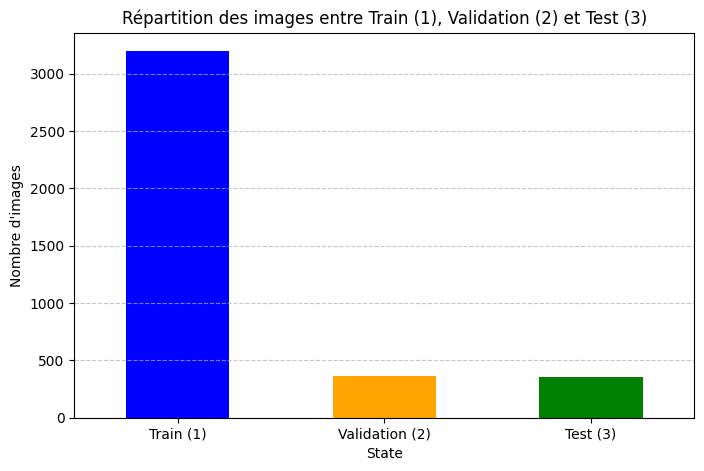

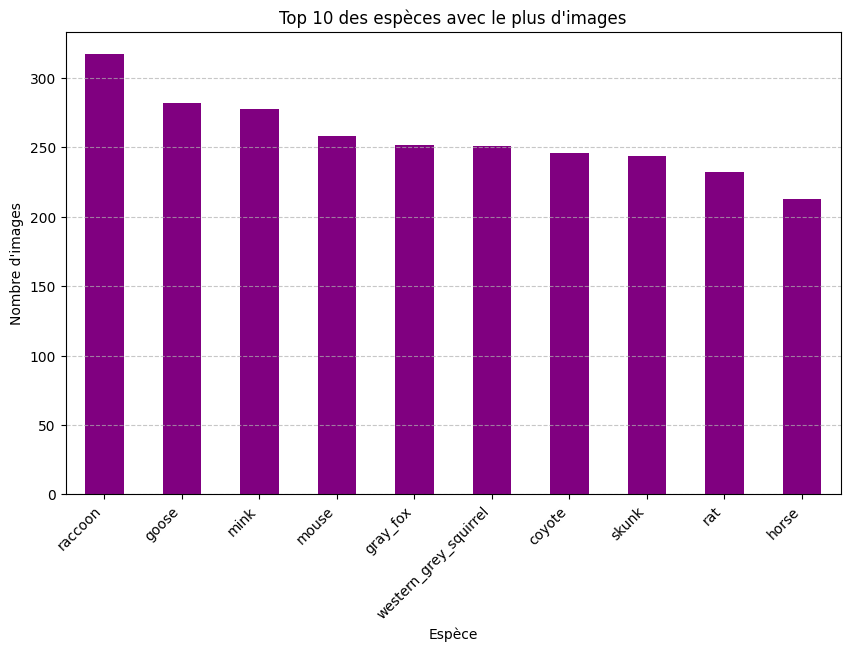

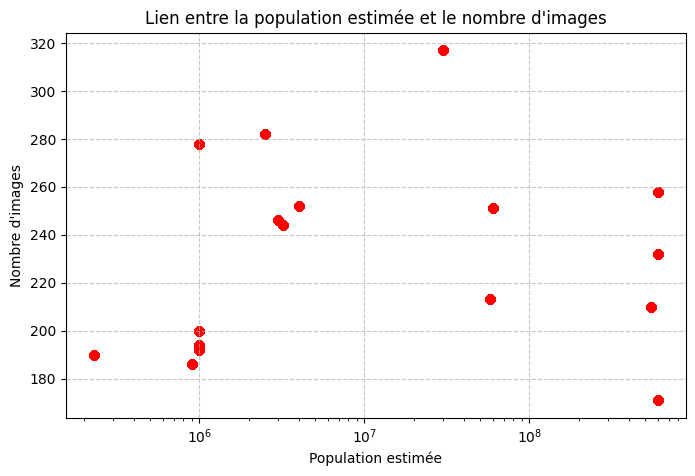

In [246]:
df_final.printSchema()
df_final.show(10)
print(f"Nombre total d'images : {df_final.count()}")
print(f"Colonnes : {df_final.columns}")

df_pandas = df_final.toPandas()

# Compter les occurrences des états (1 = train, 2 = val, 3 = test)
state_counts = df_pandas["state"].value_counts().sort_index()

# 📊 Création du graphique
plt.figure(figsize=(8, 5))
state_counts.plot(kind='bar', color=['blue', 'orange', 'green'])

plt.xlabel("State")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images entre Train (1), Validation (2) et Test (3)")
plt.xticks(ticks=[0, 1, 2], labels=["Train (1)", "Validation (2)", "Test (3)"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

# Compter le nombre d'images par espèce
species_counts = df_pandas["Espèce anglais"].value_counts().head(10)  # Top 10

# 📊 Création du graphique
plt.figure(figsize=(10, 6))
species_counts.plot(kind='bar', color='purple')

plt.xlabel("Espèce")
plt.ylabel("Nombre d'images")
plt.title("Top 10 des espèces avec le plus d'images")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(df_pandas["Population estimée"], df_pandas["Nombre d'images"], alpha=0.5, color='red')

plt.xlabel("Population estimée")
plt.ylabel("Nombre d'images")
plt.title("Lien entre la population estimée et le nombre d'images")
plt.xscale("log")  # Pour une meilleure visibilité
plt.grid(True, linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

In [249]:
from pyspark.sql import Row

# Vérifier si les états existent déjà
df_etat = spark.createDataFrame([
    Row(id_etat=1, type="train"),
    Row(id_etat=2, type="validation"),
    Row(id_etat=3, type="test")
])

# Insérer dans MySQL
df_etat.write.jdbc(url=db_url, table="wildlens_etat", mode="append", properties=db_properties)

print("✅ Table wildlens_etat mise à jour.")

Py4JJavaError: An error occurred while calling o11033.jdbc.
: java.lang.ClassNotFoundException: com.mysql.cj.jdbc.Driver
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:593)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:526)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:46)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:103)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:254)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:258)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:47)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:48)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:869)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:391)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:364)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:251)
	at org.apache.spark.sql.DataFrameWriter.jdbc(DataFrameWriter.scala:766)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)


In [ ]:
# 🔄 Fonction corrigée pour éviter le shadowing et enlever le "Nombre d'images"
def get_image_info_extended(folder_path):
    if not os.path.exists(folder_path):
        return None, None, 0, 0

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    widths_list, heights_list, sizes_kb_list, total_pixels_list = [], [], [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                img_width, img_height = img.size
                file_size_kb = os.path.getsize(img_path) / 1024
                widths_list.append(img_width)
                heights_list.append(img_height)
                sizes_kb_list.append(file_size_kb)
                total_pixels_list.append(img_width * img_height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_img_width = sum(widths_list) / len(widths_list) if widths_list else None
    avg_img_height = sum(heights_list) / len(heights_list) if heights_list else None
    avg_size_kb = sum(sizes_kb_list) / len(sizes_kb_list) if sizes_kb_list else None
    avg_total_pixels = sum(total_pixels_list) / len(total_pixels_list) if total_pixels_list else None

    return avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels

# 📊 Stockage des données étendues sans "Nombre d'images"
image_data_extended = []

for folder in df_all_animals["Nom du dossier"]:
    folder_path_raw = os.path.join(image, folder)
    avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels = get_image_info_extended(folder_path_raw)
    image_data_extended.append([folder, avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels])

# 🔗 Création DataFrame mis à jour
df_extended = pd.DataFrame(image_data_extended, columns=["Nom du dossier", "Largeur Moyenne", "Hauteur Moyenne", "Poids Moyen (Ko)", "Taille Moyenne (Pixels)"])

# 👁️‍🗨️ Affichage du DataFrame
display(df_extended)

# 📊 Nouveau graphique avec axe secondaire (sans Nombre d'images)
fig, ax1 = plt.subplots(figsize=(14,7))

x_labels = df_extended["Nom du dossier"]
x_range = range(len(x_labels))

# 📏 Axe principal pour Poids et Dimensions
ax1.bar([x + 0.15 for x in x_range], df_extended["Poids Moyen (Ko)"], width=0.15, label="Poids Moyen (Ko)", color='green')
ax1.bar([x + 0.3 for x in x_range], df_extended["Largeur Moyenne"], width=0.15, label="Largeur Moyenne", color='purple')
ax1.bar([x + 0.45 for x in x_range], df_extended["Hauteur Moyenne"], width=0.15, label="Hauteur Moyenne", color='orange')

ax1.set_xlabel("Nom du dossier")
ax1.set_ylabel("Valeurs Moyennes")
ax1.set_xticks([x + 0.225 for x in x_range])
ax1.set_xticklabels(x_labels, rotation=45)

# 📊 Axe secondaire pour la Taille Moyenne (Pixels)
ax2 = ax1.twinx()
ax2.bar([x + 0.6 for x in x_range], df_extended["Taille Moyenne (Pixels)"], width=0.15, label="Taille Moyenne (Pixels)", color='red', alpha=0.5)
ax2.set_ylabel("Taille Moyenne (Pixels)")

# 🔖 Combinaison des légendes des deux axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.title("Comparaison des caractéristiques des images par dossier")
plt.tight_layout()
plt.show()
